In [33]:
# Required libraries  
from utils_old import one_hot_encode, binarize_data, binarize_3d, plot_central_planes, plot_3d, create_dir
from utils_old import PlotSlice, PlotImage

   
import os
import glob
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import cm
import cv2

## Import dataset

In [34]:
datasets_base_path = '../03_CT_Scan_Images/' #path to directory with '.mat' datasets
datasets = glob.glob(datasets_base_path +'*.mat') #find all '.mat' datasets in the directory
dataset_names = [path.replace(datasets_base_path, '').replace('.mat', '') for path in datasets] #extract dataset name

In [35]:
id_ = 0 #TO DEFINE, index of the dataset in 'datasets' variable

print(dataset_names[id_] + ' dataset is chosen\n')
rawMatData = loadmat(datasets[id_]) # load dataset with id_ = 0
bwImage = rawMatData["bwImage"]
ctImage = rawMatData["ctImage"]

print('Data shape: ', ctImage.shape)

Beta_2_0.2 dataset is chosen

Data shape:  (516, 516, 516)


## Run binarization algorithm

In [36]:
%%time

res_3d, res_porosity = binarize_3d(ctImage)

print('Resulting shape:', res_3d.shape)

Resulting shape: (516, 516, 516)
CPU times: user 1min 29s, sys: 2.87 s, total: 1min 32s
Wall time: 38 s


Prosity: 0.3476389541056017
Thresholding accuracy: 0.9805556589123995


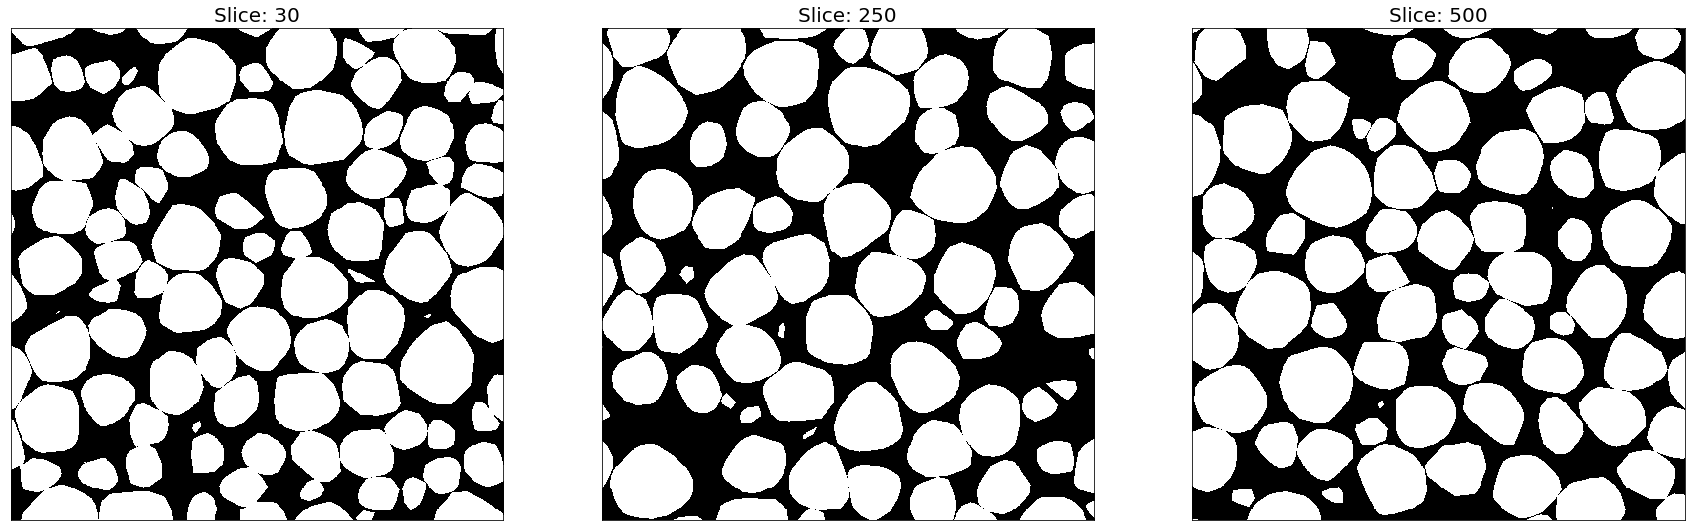

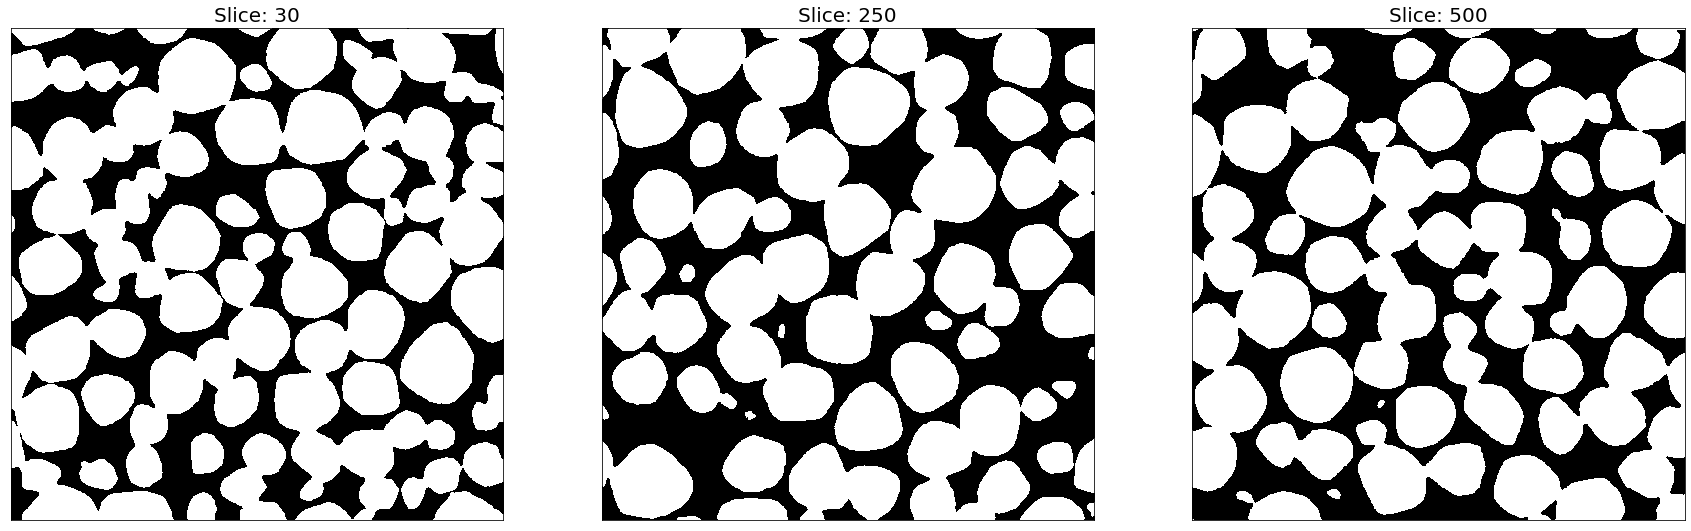

In [37]:
# Measure porosity
porosity = np.sum(bwImage==0)/np.prod(bwImage.shape)
print("Prosity: " + str(porosity))

# Measure the thresholding accuracy
accuracy = np.sum(bwImage==res_3d)/np.prod(bwImage.shape)
print("Thresholding accuracy: " + str(accuracy))

PlotImage(bwImage)
PlotImage(res_3d)

Pseodo SSA: 0.03767707065392332


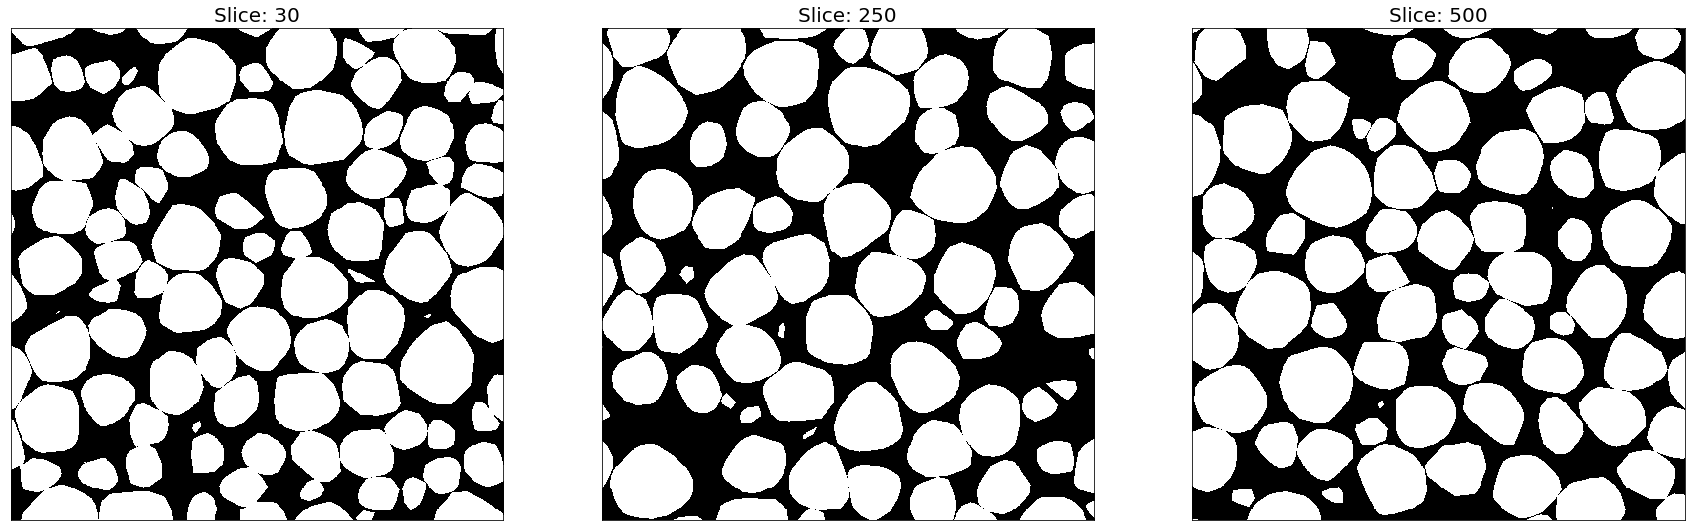

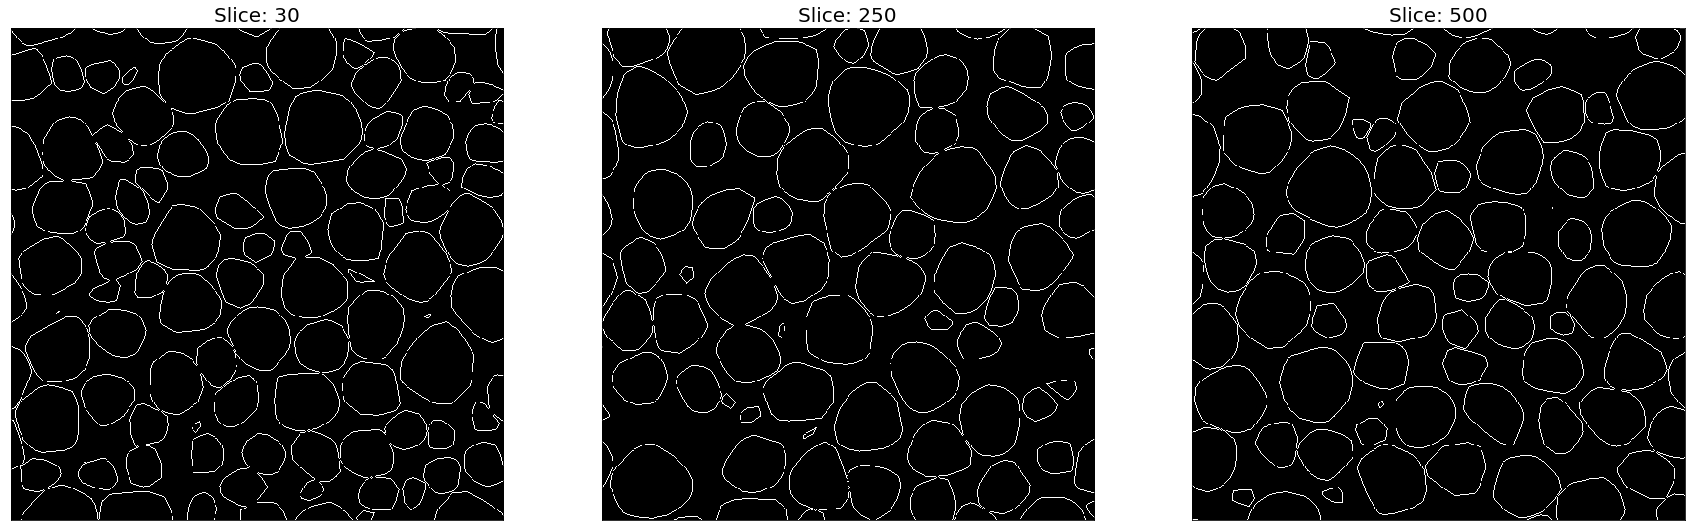

In [38]:
# Measure surface area for predicted
import os
from skimage.morphology import erosion
bwEdge = np.zeros(bwImage.shape)
for i in range(0, bwImage.shape[2]):
    image = np.squeeze(bwImage[:,:,i])
    bwEdge[:,:,i] = image - erosion(image)

PlotImage(bwImage)
PlotImage(bwEdge)

pseodoSSA = np.sum(bwEdge)/np.prod(bwEdge.shape)
print("Pseodo SSA: " + str(pseodoSSA))

Pseodo SSA: 0.03351416996127525


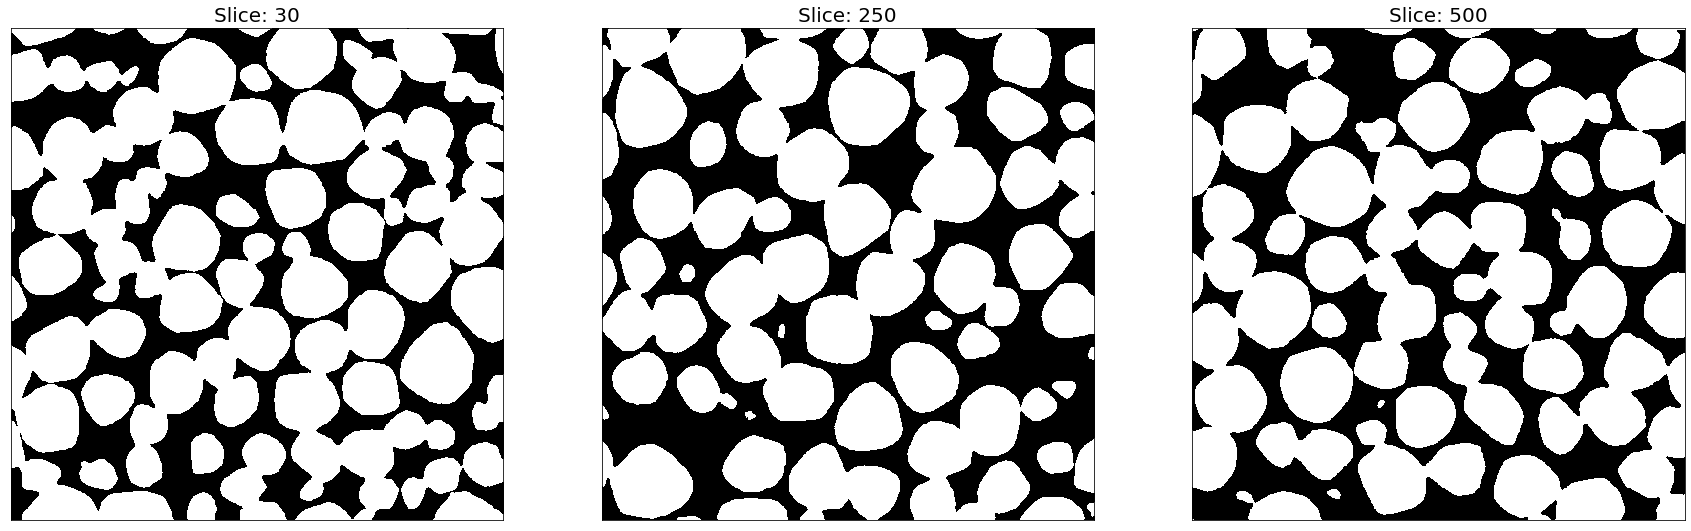

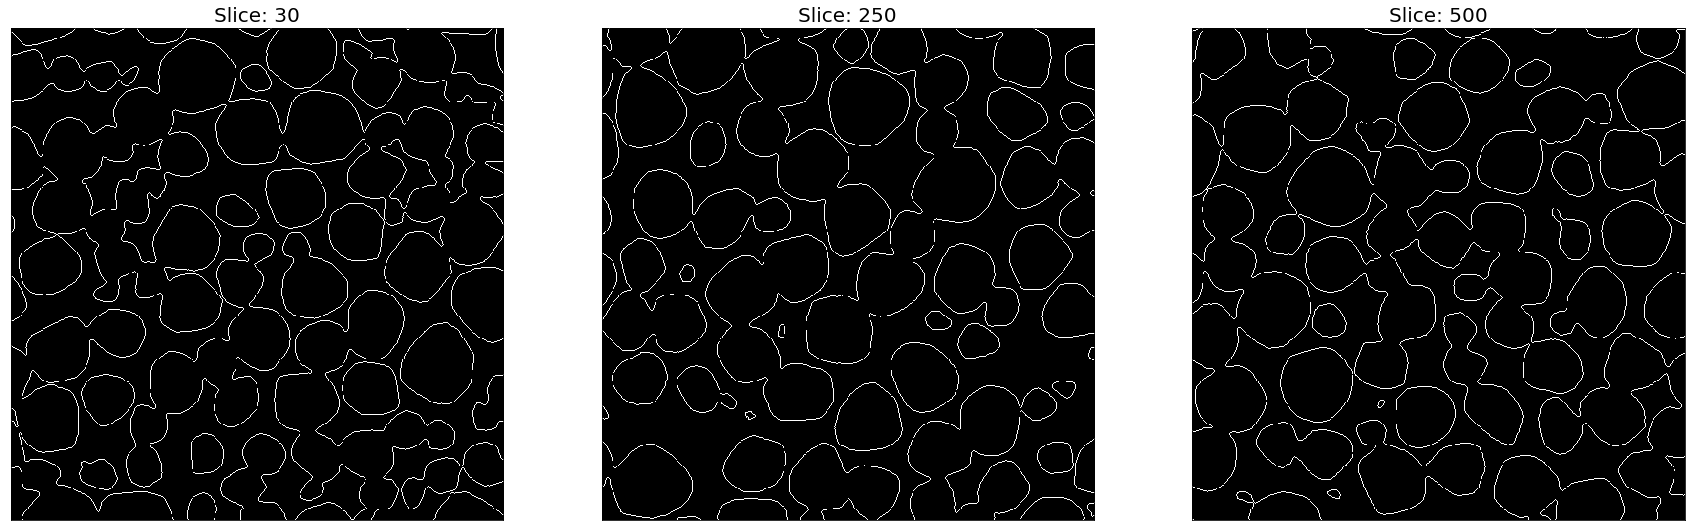

In [39]:
# Measure surface area
bwEdge = np.zeros(res_3d.shape)
for i in range(0, res_3d.shape[2]):
    image = np.squeeze(res_3d[:,:,i])
    bwEdge[:,:,i] = image - erosion(image)

PlotImage(res_3d)
PlotImage(bwEdge)

pseodoSSA = np.sum(bwEdge)/np.prod(bwEdge.shape)
print("Pseodo SSA: " + str(pseodoSSA))

## Apply watershed

In [41]:
from utils import one_hot_encode, binarize_data, binarize_3d, plot_central_planes, plot_3d, create_dir

In [42]:
%%time

filters = {'bilateral': [3, 25, 25], 'sharpen': None}
res_3d = []
for i in range(ctImage.shape[0]):
    res, res_watershed, res_porosity = binarize_data(
        img=ctImage[i, :, :],
        k=2,
        filters=filters,
        foot=30
    )
    res_3d.append(res_watershed)
res_3d=np.array(res_3d)

print('Resulting shape:', res_3d.shape)

Resulting shape: (516, 516, 516)
CPU times: user 5min 24s, sys: 6.23 s, total: 5min 31s
Wall time: 1min 15s


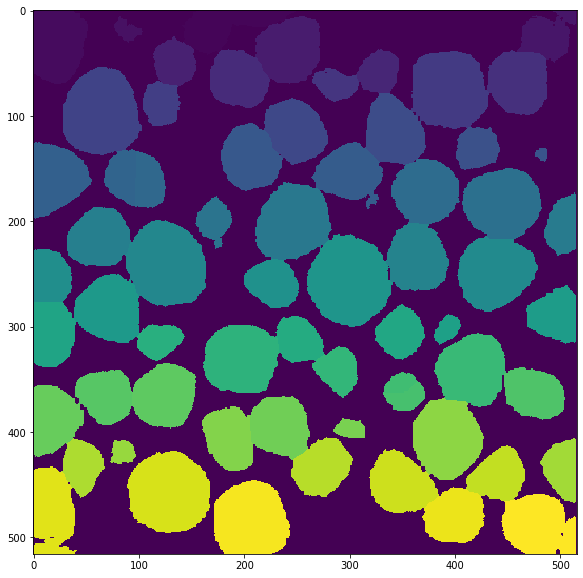

In [43]:
plt.figure(figsize=(10, 10))
plt.imshow(res_3d[0,:,:])

In [44]:
out_3d = []
for i in range(res_3d.shape[0]):
    values = np.unique(res_3d[i,:,:])
    kernel = np.ones((2,2), np.uint8)
    out = np.zeros_like(res_3d[i,:,:], np.uint8)
    for value in values:
        if value == 0:
            erosion = out
        else:
            mask = np.where(res_3d[i,:,:]==value, 1, 0)
            erosion = cv2.erode(np.uint8(mask), kernel, iterations=1)
        out += erosion * value
    out_3d.append(out)
out_3d=np.array(out_3d)
out_3d[out_3d>0]=1

In [45]:
out_3d.shape

(516, 516, 516)

## Plot binarized cube

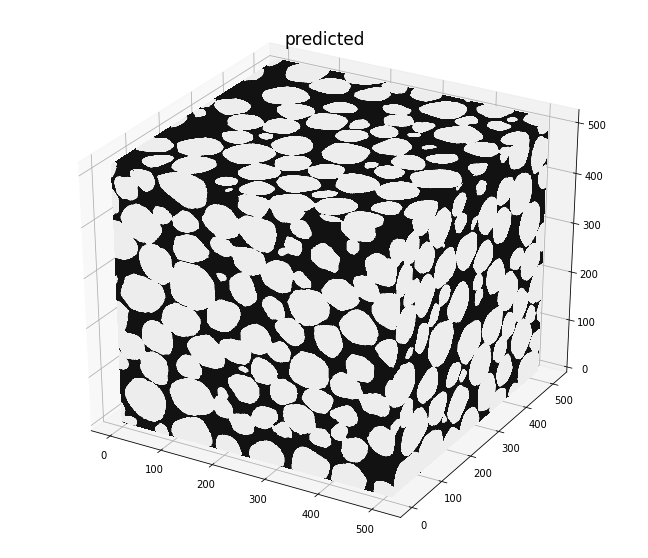

In [6]:
plot_3d(res_3d, img_title='predicted')

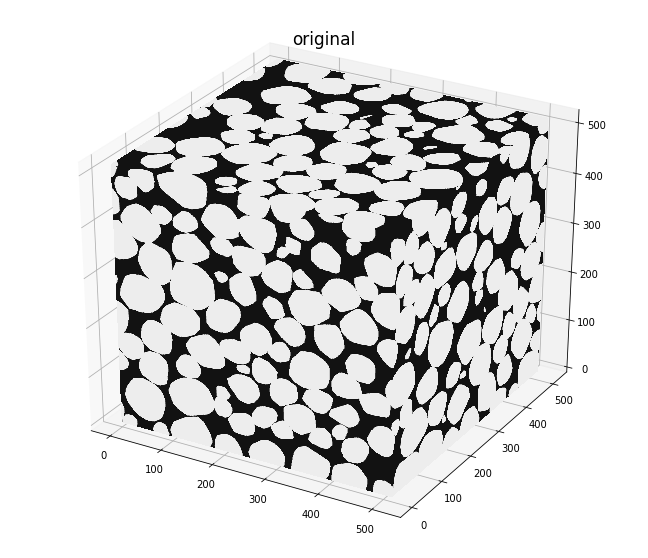

In [7]:
plot_3d(bwImage, img_title = 'original')

## Visualize orthogonal central planes

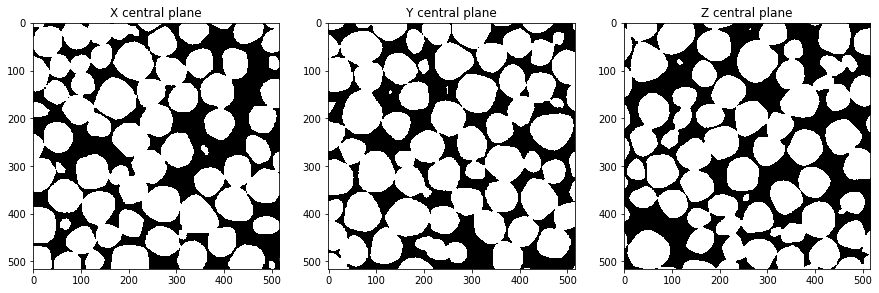

In [8]:
#predicted
plot_central_planes(res_3d)

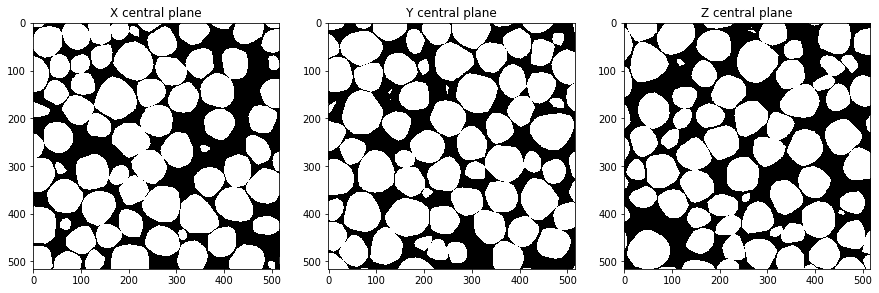

In [9]:
#original
plot_central_planes(bwImage)

## Plot porosity

In [24]:
#estimate original porosity
original_porosity = []
for bw_img_orig in bwImage:
    original_porosity.append(np.sum(bw_img_orig==0)/np.prod(bw_img_orig.shape))

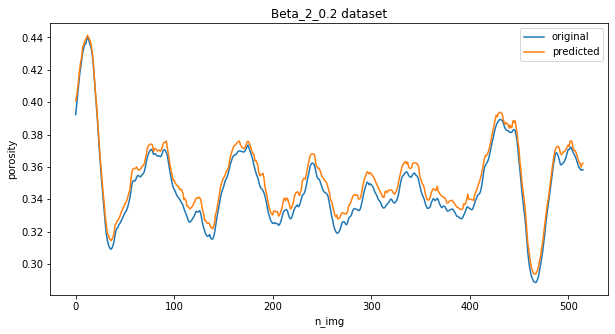

In [28]:
plt.figure(figsize = (10,5))
plt.title(dataset_names[id_] + ' dataset')
plt.plot(original_porosity, label = 'original')
plt.plot(res_porosity, label = 'predicted')
plt.ylabel('porosity')
plt.xlabel('n_img')
plt.legend()
plt.show()